# Lunar Lander
The objective of this exercise is to land a lunar lander gently on the surface of the moon. The lunar lander environment is provided by [Open AI Gym](https://github.com/openai/gym). The gym environment receives an action and returns a reward value and the new state of the lander. The state of the lander is a 8 dimensional vector with the following components.
* The coordinates of the lander in x & y.
* Its linear velocities in x & y.
* Its angle.
* Its angular velocity.
* Two booleans that represent whether each leg is in contact with the ground or not.

The action is derieved from a set of 4 discrete values:
* 0 (Do nothing)
* 1 (Fire the left orientation engine)
* 2 (Fire the main engine)
* 3 (Fire the right orientation engine)]

The gym environment can receive one action at each timestep.

# References
* [RL using OpenAI Gym](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)
* [Deep Q-Learning](https://github.com/adventuresinML/adventures-in-ml-code/blob/master/r_learning_tensorflow.py)
* [Lunar Lander by vsaveris](https://github.com/vsaveris/lunar-lander-DQN)

In [1]:
%%capture
# Let's start by installing a few required packages. The installation requirements depend on the execution environments.

# Lunar Lander gym environment.
! pip install gym gym[box2d]

# Visualization of the animation.
! pip install ipywidgets

In [2]:
%%capture
# simple neural network implementation of qlearning
import gym
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import layers, optimizers
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from collections import deque
from statistics import mean

## Initialization

/opt/conda/lib/python3.7/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/opt/conda/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/opt/conda/lib/python3.7/site-packages/gym

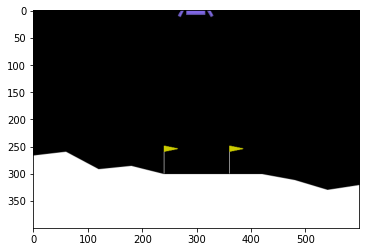

In [3]:
seed = 111

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For Kaggle
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Lunar Lander environment initialization
env = gym.make("LunarLander-v2")
obs = env.reset()
image = env.render(mode='rgb_array')
plt.imshow(image)

## Lander Model

In [4]:
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

def create_model():
    """Construct the critic network with q-values per action as output"""
    model = keras.Sequential([
        layers.Input(shape=(N_STATES)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu", name='prunable'),
        layers.Dense(N_ACTIONS, activation='linear')
    ])
    
    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

model = create_model()
model.summary()

2022-08-27 05:05:34.257490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 05:05:34.385155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 05:05:34.385999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
prunable (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________


2022-08-27 05:05:34.387819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-27 05:05:34.388164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 05:05:34.388871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 05:05:34.389552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Training
The training process involves two phases which occur alternatively for each episode. An episode terminates with a successful landing, a crash or the expiration of allowed timesteps (1000 steps). The 'Trainer' collects experience in the first phase by interacting with the gym environment. The model is training in the second phase using the accumulated experiences.

The loss function used in this exercise is the Q Learning Loss function which takes the next state rewards into account for the current state rewards. It's akin to looking one timestep in the future.

In [5]:
GAMMA = .99
DECAY_FACTOR = .99995
BATCH_SIZE = 64
MAX_EPISODES = 800
# MAX_EPISODES = 2
ACCEPTABLE_AVERAGE_SCORE_THRESHOLD = 190
MAX_ACCEPTABLE_AVG_SCORE_COUNTER = 100

def Trainer(m, callbacks=[]):
    memory = []
    last_100_scores = deque(maxlen=100)
    epsilon = 1.0
    acceptable_avg_score_counter = 0

    def choosePlay(state):
        nonlocal epsilon
        random_action = lambda: np.random.randint(N_ACTIONS)
    
        def predicted_action():
            q_values = m(tf.expand_dims(state, 0))
            action = tf.squeeze(tf.argmax(q_values, axis=-1))
            return action.numpy()
        
        action =  random_action() if np.random.random() <= epsilon else predicted_action()
        epsilon *= DECAY_FACTOR

        return action
    
    def obs_to_state(obs):
        state = np.squeeze(obs)
        return state

    def play(state):
        action = choosePlay(state)
        obs, reward, done, _ = env.step(action)
        new_state = obs_to_state(obs)

        return action, reward, new_state, done
    
    def train_step(state):
        # Play to gain experience
        action, reward, new_state, done = play(state)
        new_state = np.zeros_like(state) if done else new_state

        # Store experience in the memory bank
        memory.append((state, action, reward, new_state))

        # Train the network with a batch of the gained experience
        batch = np.asarray(random.sample(memory, min(len(memory), BATCH_SIZE)), dtype=object)
        q_s_a = m.predict(np.stack(batch[:, 0], axis = 0))  #Q(s,a)   
        q_s_a_next = m.predict(np.stack(batch[:, 3], axis = 0))  #Q(s',a)

        for item_id in range(batch.shape[0]):
            if np.array_equal(batch[item_id, 3], np.zeros(N_STATES)):
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2]
            else:
                q_s_a[item_id, batch[item_id, 1]] = batch[item_id, 2] + GAMMA*np.amax(q_s_a_next[item_id, :])

        m.fit(np.stack(batch[:, 0], axis = 0), q_s_a, batch_size=BATCH_SIZE, verbose=0, callbacks=callbacks)
        
        return new_state, reward, done
    
    def record_episode(episode_id, step_id, score, reward, results):
        nonlocal acceptable_avg_score_counter

        # Update the last 100 scores queue with the latest score
        last_100_scores.append(score)

        # Collect episode results
        mean_last_100_scores = mean(last_100_scores)
        results.append((step_id, reward, score, mean_last_100_scores))
        
        # Increment the counter if the episode scores past the acceptance threshold
        # Reset the counter if the episode falls below the acceptance threshold
        if mean_last_100_scores > ACCEPTABLE_AVERAGE_SCORE_THRESHOLD:
            acceptable_avg_score_counter += 1
        else:
            acceptable_avg_score_counter = 0

        print(
            'Episode:', episode_id,
            'Steps:', step_id,
            'Score:', score,
            '100_rolling_average:', mean_last_100_scores,
            'Acceptable Average Score Count:', acceptable_avg_score_counter,
        )

    def train(episodes=MAX_EPISODES, steps=1000):
        results = []

        for episode_id in range(episodes):
            obs = env.reset()
            state = obs_to_state(obs)
            score = 0

            for step_id in range(steps):
                state, reward, done = train_step(state)
                score += reward
                
                if done:
                    record_episode(episode_id, step_id, score, reward, results)
                    break
            
            # Terminate training if the average score meet the acceptance threshold
            # for MAX_ACCEPTABLE_AVG_SCORE_COUNTER episodes in sequence.
            if acceptable_avg_score_counter >= MAX_ACCEPTABLE_AVG_SCORE_COUNTER:
                break

        return results
    
    return train

trainer = Trainer(model)
results = trainer()

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(results, f)

model.save_weights('lunar_lander.h5')

2022-08-27 05:05:37.109642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Episode: 0 Steps: 76 Score: -126.94518349757068 100_rolling_average: -126.94518349757068 Acceptable Average Score Count: 0
Episode: 1 Steps: 76 Score: -120.9629259132142 100_rolling_average: -123.95405470539245 Acceptable Average Score Count: 0
Episode: 2 Steps: 92 Score: -167.29059957852235 100_rolling_average: -138.3995696631024 Acceptable Average Score Count: 0
Episode: 3 Steps: 107 Score: -424.71909122085106 100_rolling_average: -209.97945005253956 Acceptable Average Score Count: 0
Episode: 4 Steps: 102 Score: -220.22531169060517 100_rolling_average: -212.02862238015268 Acceptable Average Score Count: 0
Episode: 5 Steps: 67 Score: -92.93395319781692 100_rolling_average: -192.1795108497634 Acceptable Average Score Count: 0
Episode: 6 Steps: 109 Score: -57.95470608031849 100_rolling_average: -173.0045387398427 Acceptable Average Score Count: 0
Episode: 7 Steps: 66 Score: -108.16367587241754 100_rolling_average: -164.89943088141456 Acceptable Average Score Count: 0
Episode: 8 Steps: 6

2022-08-27 06:21:41.746399: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


Episode: 157 Steps: 999 Score: -66.84642834813847 100_rolling_average: -87.31353643169888 Acceptable Average Score Count: 0
Episode: 158 Steps: 729 Score: 176.02621396155504 100_rolling_average: -84.68319080543729 Acceptable Average Score Count: 0
Episode: 159 Steps: 344 Score: -166.5202284862376 100_rolling_average: -84.58833765712296 Acceptable Average Score Count: 0
Episode: 160 Steps: 564 Score: 207.61580711399 100_rolling_average: -81.77028794078822 Acceptable Average Score Count: 0
Episode: 161 Steps: 999 Score: 34.875258644633185 100_rolling_average: -79.70405112892334 Acceptable Average Score Count: 0
Episode: 162 Steps: 653 Score: 221.3897629087984 100_rolling_average: -75.70340226881875 Acceptable Average Score Count: 0
Episode: 163 Steps: 611 Score: 211.72971739533872 100_rolling_average: -71.57143244912294 Acceptable Average Score Count: 0
Episode: 164 Steps: 999 Score: -45.16695195462117 100_rolling_average: -70.93244797601616 Acceptable Average Score Count: 0
Episode: 165

Label(value='Training Results')

,Steps,Reward,Score,R100_Score,Done,Crashed
0,76,-100.0,-126.945183,-126.945183,False,True
1,76,-100.0,-120.962926,-123.954055,False,True
2,92,-100.0,-167.290600,-138.399570,False,True
3,107,-100.0,-424.719091,-209.979450,False,True
4,102,-100.0,-220.225312,-212.028622,False,True
...,...,...,...,...,...,...
473,368,100.0,255.445212,215.116354,True,False
474,392,100.0,236.937875,215.178598,True,False
475,495,100.0,261.143951,216.258702,True,False
476,453,100.0,212.897971,215.707528,True,False


Successes: 260 Crashes: 169 Timeouts: 49


Label(value='Top Scores')

,Steps,Reward,Score,R100_Score,Done,Crashed
423,266,100.0,303.316471,204.467323,True,False
233,369,100.0,300.338252,88.209924,True,False
464,366,100.0,290.974344,210.675956,True,False
425,312,100.0,287.346204,206.371294,True,False
235,312,100.0,284.314987,92.489142,True,False


Label(value='Bottom Scores')

,Steps,Reward,Score,R100_Score,Done,Crashed
9,160,-100.0,-299.574213,-168.829784,False,True
263,344,-100.0,-328.215407,121.471196,False,True
231,366,-100.0,-343.590563,82.268659,False,True
3,107,-100.0,-424.719091,-209.979450,False,True
312,910,-100.0,-440.150888,115.851661,False,True


Label(value='Training Benchmarks')

,Start,End,Count,Successes,Crashes,Timeouts
0,0,200,128,0,128,0
1,200,300,21,10,11,0
2,300,500,144,124,20,0
3,500,700,89,85,4,0
4,700,1000,96,41,6,49


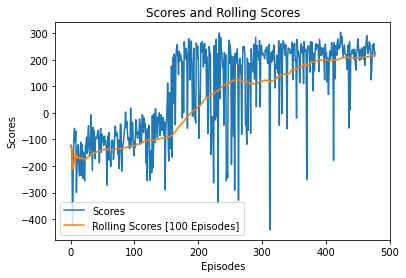

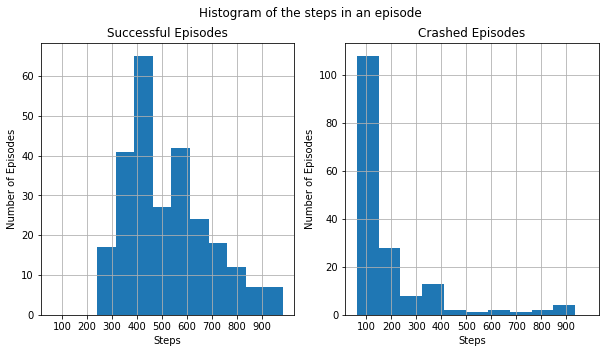

In [6]:
from ipywidgets import Label

def load_results(file):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        columns = ['Steps', 'Reward', 'Score', 'R100_Score']
        return pd.DataFrame(results, columns=columns)

def show_results(df):
    df['Done'] = df['Reward'] == 100
    df['Crashed'] = df['Reward'] == -100

    # Plot rolling scores
    plt.plot(df['Score'], label='Scores')
    plt.plot(df['R100_Score'], label='Rolling Scores [100 Episodes]')
    plt.legend()
    plt.title('Scores and Rolling Scores')
    plt.xlabel('Episodes')
    plt.ylabel('Scores')

    display(Label('Training Results'), df)

def summarize_results(file):
    df = load_results(file)
    show_results(df)

    # Display Summary
    successes = len(df[df['Done'] == True])
    crashes = len(df[df['Crashed'] == True])
    timeouts = len(df.loc[(df['Crashed'] == False) & (df['Done'] == False)])
    print('Successes:', successes, 'Crashes:', crashes, 'Timeouts:', timeouts)

    # Top and bottom scores
    sorted_scores = df.sort_values('Score', ascending=False)
    display(Label('Top Scores'), sorted_scores.head())
    display(Label('Bottom Scores'), sorted_scores.tail())
    
    steps_benchmarks = [0, 200, 300, 500, 700, 1000]
    benchmark_df = pd.DataFrame(columns=['Start', 'End', 'Count', 'Successes', 'Crashes', 'Timeouts'])

    for bm in range(1, len(steps_benchmarks)):
        start, end = steps_benchmarks[bm - 1], steps_benchmarks[bm]
        range_cond = (df['Steps']>=start) & (df['Steps']<end)

        count = len(df.loc[range_cond])
        successes = len(df.loc[range_cond & df['Done'] == True])
        crashes = len(df.loc[range_cond & df['Crashed'] == True])
        timeouts = len(df.loc[range_cond & (df['Crashed'] == False) & (df['Done'] == False)])

        benchmark_df.loc[bm-1] = (start, end, count, successes, crashes, timeouts)
    
    # Training Benchmarks
    display(Label('Training Benchmarks'), benchmark_df)

    # Episode Steps Histogram
    successes_df = df.loc[df['Done'] == True]['Steps']
    crashes_df = df.loc[df['Crashed'] == True]['Steps']

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
    successes_df.hist(ax=axes[0])
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Number of Episodes')
    axes[0].set_title('Successful Episodes')
    axes[0].set_xticks(range(0, 1000, 100))

    crashes_df.hist(ax=axes[1])
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Number of Episodes')
    axes[1].set_title('Crashed Episodes')
    fig.suptitle('Histogram of the steps in an episode')

# summarize_results('v23/lunar_lander.results.pkl')
summarize_results('lunar_lander.results.pkl')

## Trial Run

In [7]:

def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render(mode='rgb_array')
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))
       
    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,2e9))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

def trial_run(m):
    def obs_to_state(obs):
        state = np.squeeze(obs)
        return state
    
    def predicted_action(state):
        q_values = m(tf.expand_dims(state, 0))
        action = tf.squeeze(tf.argmax(q_values, axis=-1))
        return action.numpy()

    obs = env.reset()
    score = 0
    frames = []

    for step_id in range(1000):
        state = obs_to_state(obs)
        action = predicted_action(state)
        obs, reward, done, _ = env.step(action)
        score += reward
        
        # Save visuals
        save_visuals(env, frames)

        if done:
            print('Finished with total score:', score, 'in steps: ', step_id)
            break
    
    print('Total Score:', score, 'Done:', done)
    return frames

# model.load_weights('v23/lunar_lander.h5')
container, frames = {}, trial_run(model)
save_frames_as_gif(container, 0, frames)

/opt/conda/lib/python3.7/site-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


Finished with total score: 203.05218618344952 in steps:  453
Total Score: 203.05218618344952 Done: True


## Animation Visualization

In [8]:
import ipywidgets as ipyw

def create_expanded_button(description, button_style):
    return ipyw.Button(description=description, button_style=button_style, layout=ipyw.Layout(height='auto', width='auto'))

def image_widget(file):
    with open(file, "rb") as file:
        image = file.read()
        # return Image(value=image, width=w, height=h)
        return ipyw.Image(value=image)

def image_label_widget(title, file):
    image = image_widget(file)
    label = ipyw.Label(value=title)
    layout = ipyw.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid')
    box = ipyw.Box(children=[image, label], layout=layout)
    return box

def display_gifs_grid(images, cols=5):
    rows = (len(images)+cols-1) // cols
    grid = ipyw.GridspecLayout(rows, cols)

    for index, image in images.items():
        gcol = index%cols
        grow = index//cols

        grid[grow, gcol] = image_label_widget(str(index), image)
    
    return grid

display_gifs_grid(container, cols=1)


GridspecLayout(children=(Box(children=(Image(value=b'GIF89aX\x02\x90\x01\x87\x00\x00\xff\xff\xff\xfc\xfc\xfc\x…

<img src='./lunar_lander.0.616047345.gif'>